# Explainable Insurance Purchase Prediction

## Project Snapshot
This project predicts whether a customer is likely to purchase an insurance product based on demographic and behavioral features.

The goal is not only accurate prediction, but **transparent decision-making**, allowing stakeholders to understand *why* a customer is classified as likely or unlikely to purchase.

- Task: Binary classification
- Target: Insurance purchase (Yes / No)
- Primary metric: ROC-AUC
- Focus: Model interpretability (global and local explanations)


## Data Overview

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap



In [14]:
DATA_PATH = os.path.join("..", "data\\raw", "customer.csv")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (72458, 15)


,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


In [15]:
print("Information about the dataset:\n")
df.info()

Information about the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [16]:
print("Descriptive statistics:")
df.describe()

Descriptive statistics:


,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


In [17]:
df['age'] = df['age'].replace(0, np.nan)
print(f'There are {df.isnull().any().sum()} variables in train dataset with missing values.')

There are 6 variables in train dataset with missing values.


## Exploratory Data Analysis

### Target distribution
We first examine the distribution of health insurance ownership to understand class balance.


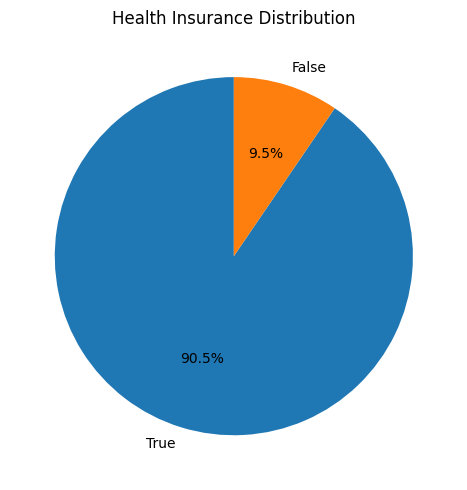

In [18]:
insurance_counts = df["health_ins"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(
    insurance_counts,
    labels=insurance_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Health Insurance Distribution")
plt.tight_layout()
plt.show()

### Age distribution
We inspect the age distribution of customers to understand demographic coverage and potential non-uniformity.


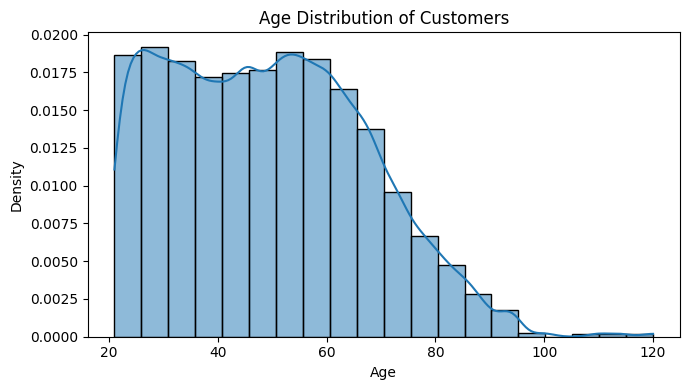

In [19]:
plt.figure(figsize=(7, 4))

sns.histplot(
    df["age"],
    bins=20,
    kde=True,
    stat="density",
    edgecolor="black"
)

plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Age Distribution of Customers")
plt.tight_layout()
plt.show()


The age distribution includes implausible values (zeros and ages exceeding 100), indicating potential data quality issues.  
These values are retained at this stage and will be addressed explicitly during preprocessing.


### Income distribution
The income distribution is examined to assess skewness and the presence of extreme values.


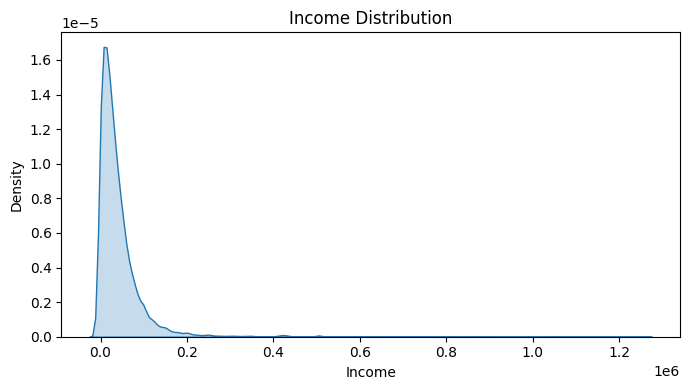

In [20]:
plt.figure(figsize=(7, 4))

sns.kdeplot(
    df["income"],
    fill=True,
    bw_adjust=1,
)

plt.xlabel("Income")
plt.ylabel("Density")
plt.title("Income Distribution")
plt.tight_layout()
plt.show()


Income values are more concentrated in the lower values and we also see that there are negative values with some relevant density. To finalize by describing the data to look to the numbers.

### State of residence
The distribution of customers across states is examined to identify geographic concentration and sparsity.


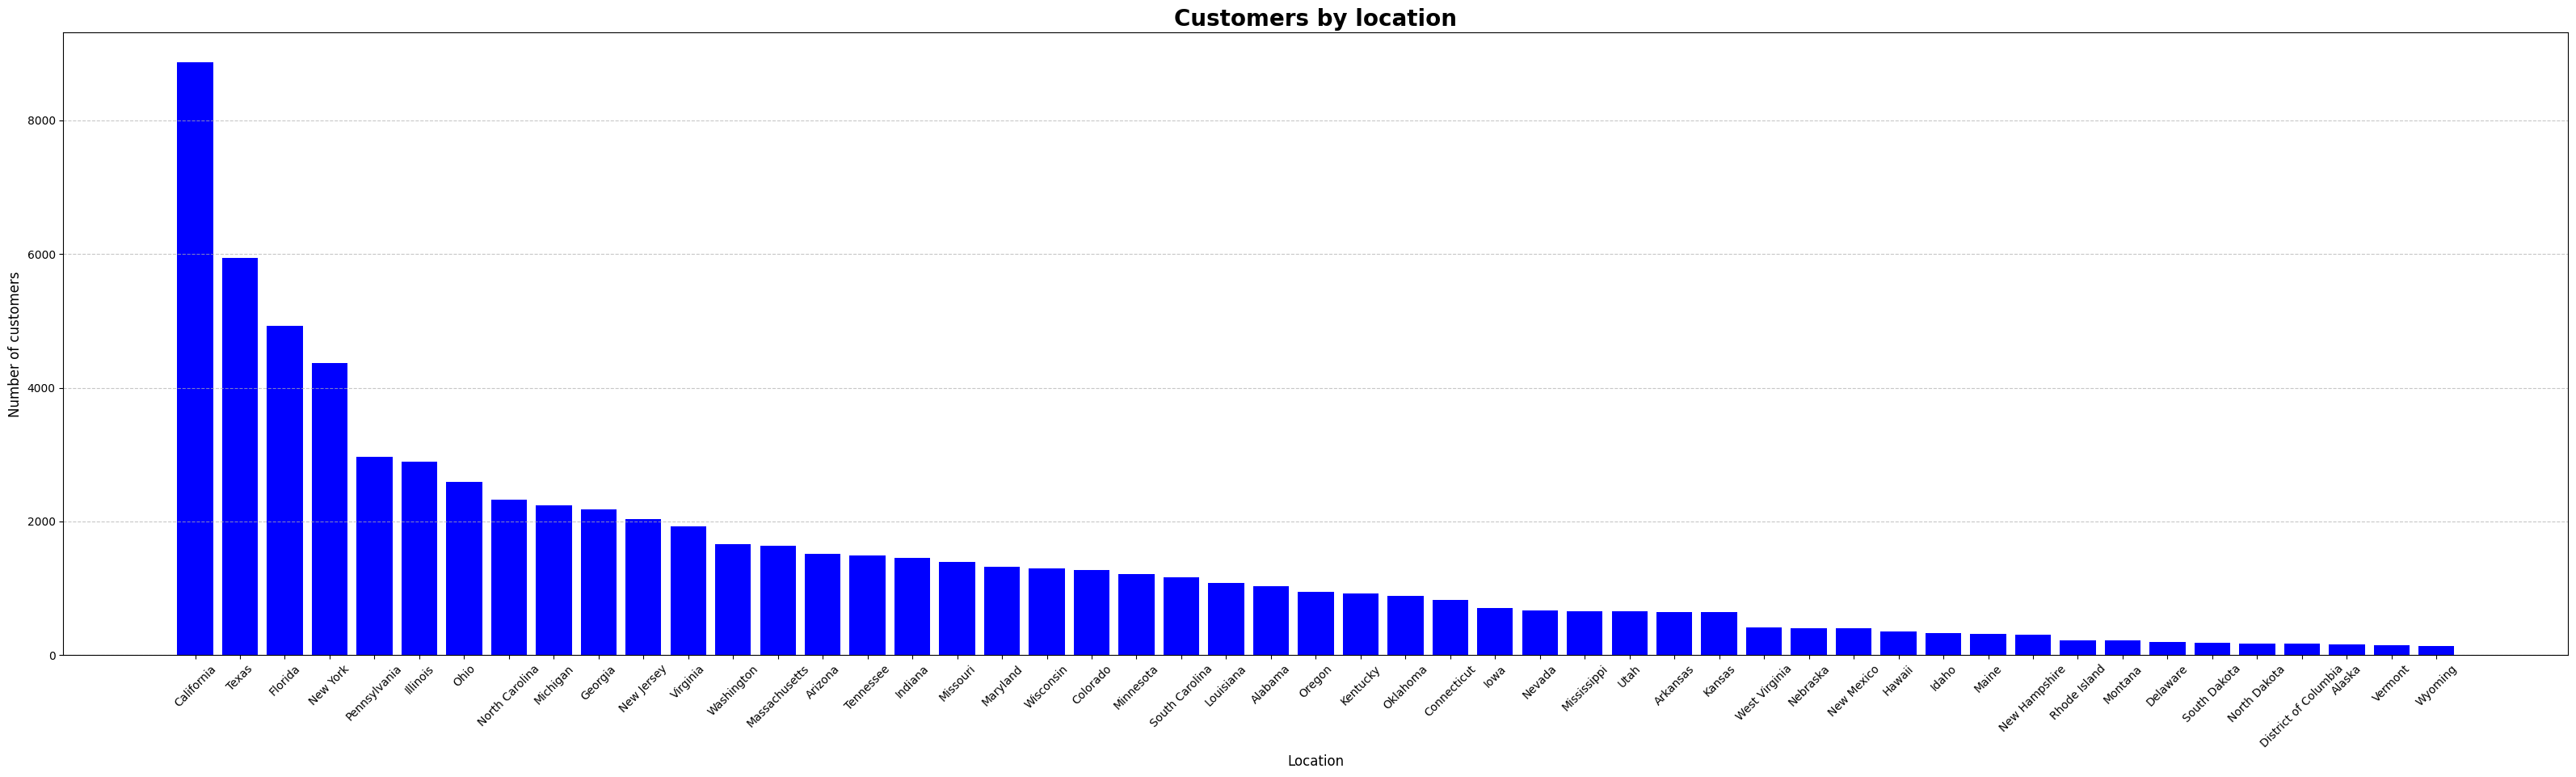

In [21]:
location_counts = df.groupby('state_of_res', as_index=False).count().sort_values(by='custid', ascending=False)

plt.figure(figsize=(40, 10))
plt.bar(location_counts['state_of_res'], location_counts['custid'], color='blue')
plt.title('Customers by location', fontsize=20, fontweight='bold')
plt.xlabel('Location', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Income is examined across states to assess whether geographic location is associated with systematic differences in income levels.


Average income is computed by state to compare income levels across geographic regions.

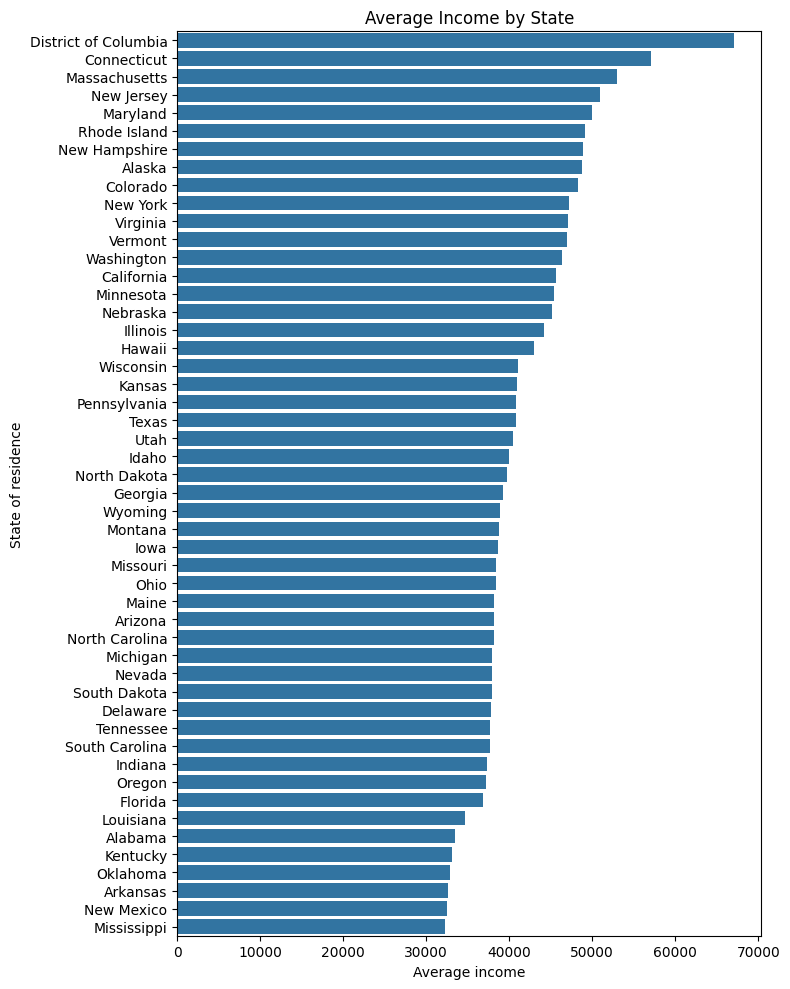

In [22]:
# Compute average income by state
avg_income_state = (
    df.groupby("state_of_res")["income"]
      .mean()
      .sort_values(ascending=False)
)

# Limit to top N states by average income for readability
TOP_N = 50
avg_income_state_top = avg_income_state.head(TOP_N)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=avg_income_state_top.values,
    y=avg_income_state_top.index,
    orient="h"
)

plt.xlabel("Average income")
plt.ylabel("State of residence")
plt.title(f"Average Income by State")
plt.tight_layout()
plt.show()


### Gender and income
Income distributions are compared across genders to assess potential systematic differences.


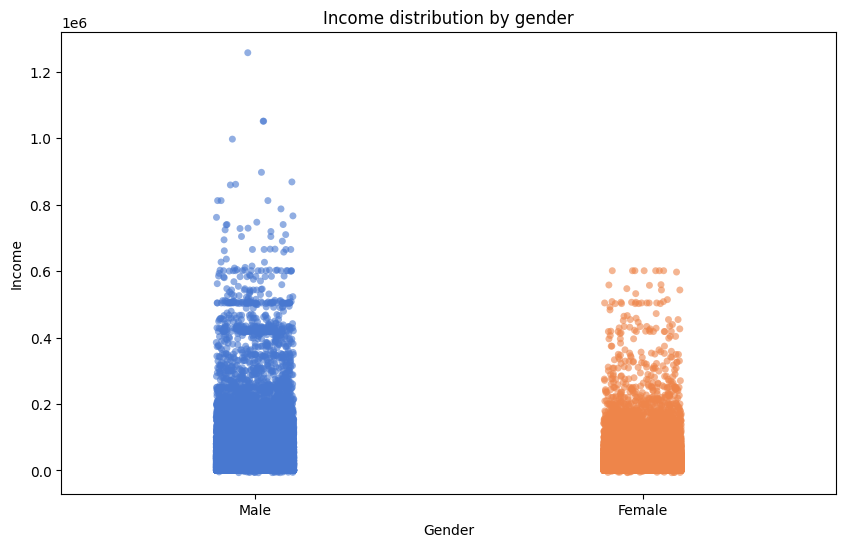

In [23]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='sex', y='income', data=df, jitter=True, alpha=0.6, palette='muted')
plt.title('Income distribution by gender')
plt.xlabel('Gender')
plt.ylabel('Income')
plt.show()

### Marital status and income
Income distributions are compared across marital status categories to examine differences associated with household structure.


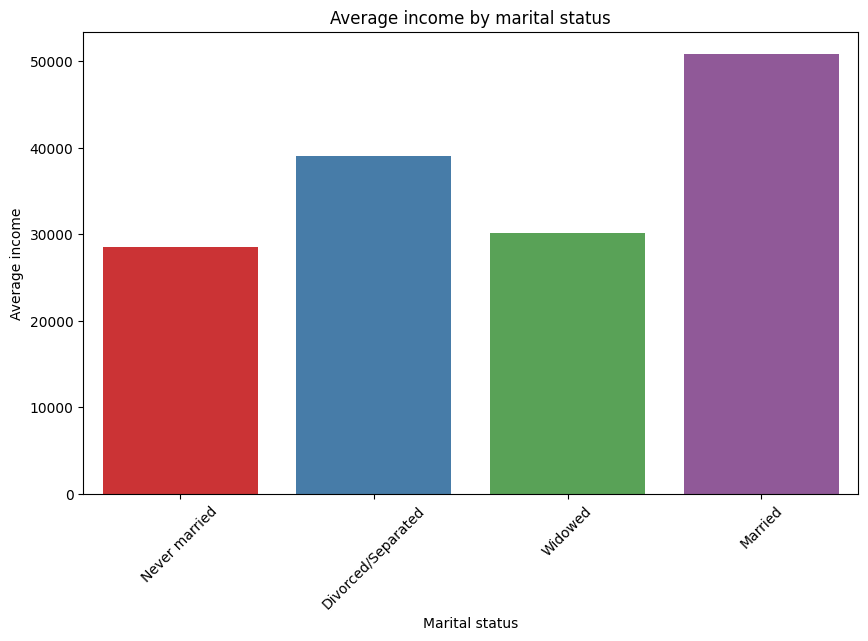

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='marital_status', y='income', data=df, ci=None, palette='Set1')
plt.title('Average income by marital status')
plt.xlabel('Marital status')
plt.ylabel('Average income')
plt.xticks(rotation=45)
plt.show()


### Probability of health insurance by age
The relationship between age and the likelihood of having health insurance is examined by estimating insurance rates across age groups.


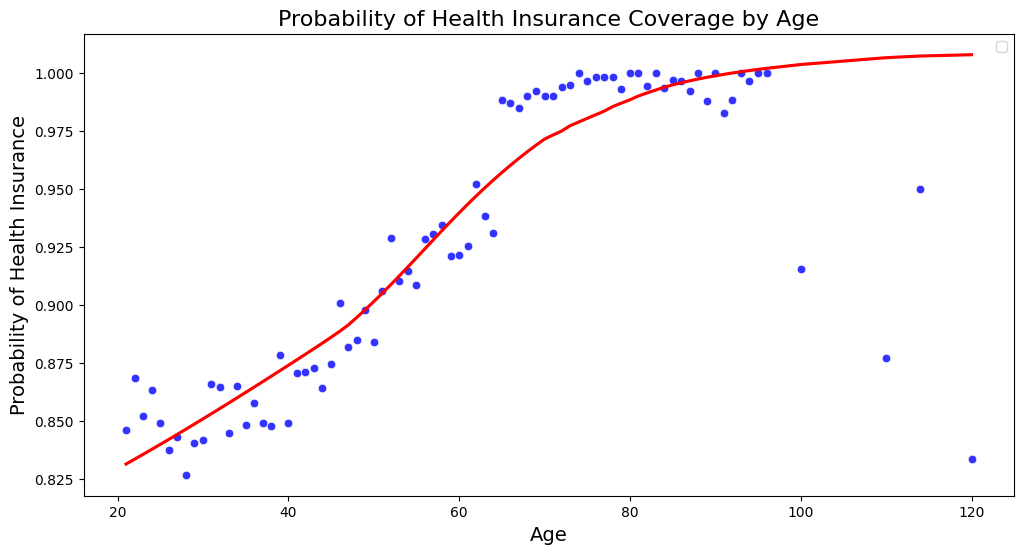

In [25]:
age_health_prob = df.groupby('age')['health_ins'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='age', y='health_ins', data=age_health_prob, color='blue', alpha=0.8)
# Add a trend line to show the general pattern
sns.regplot(x='age', y='health_ins', data=age_health_prob, scatter=False, color='red', 
            lowess=True, line_kws={'label': "Trend line"})
plt.title('Probability of Health Insurance Coverage by Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Probability of Health Insurance', fontsize=14)
plt.legend()
plt.show()


### Health insurance and marital status
Health insurance ownership is examined across marital status categories to identify potential differences associated with household structure.


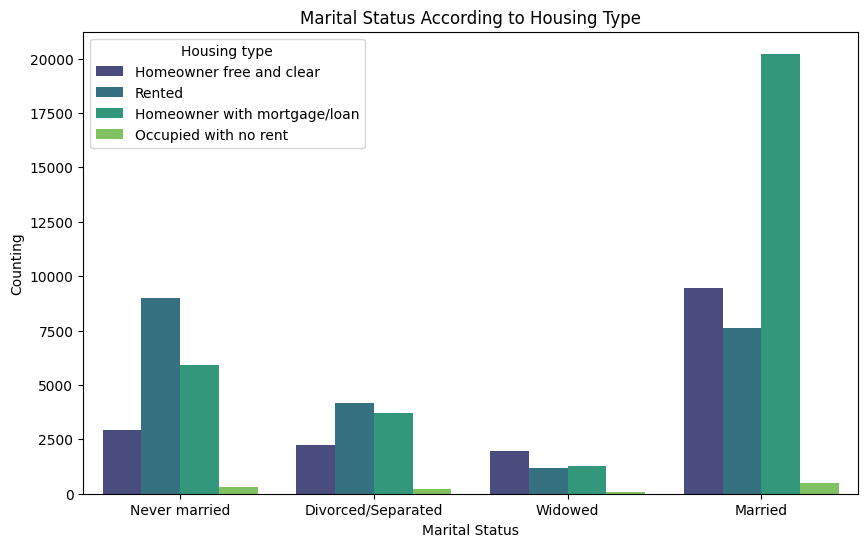

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='marital_status', hue='housing_type', data=df, palette='viridis')
plt.title('Marital Status According to Housing Type')
plt.xlabel('Marital Status')
plt.ylabel('Counting')
plt.legend(title='Housing type')
plt.show()

Almost all housing types are more represented among married people, with the exception of rented houses, which are more represented among never married people.

Let's try to understand the distribution of health insurance by martial status.

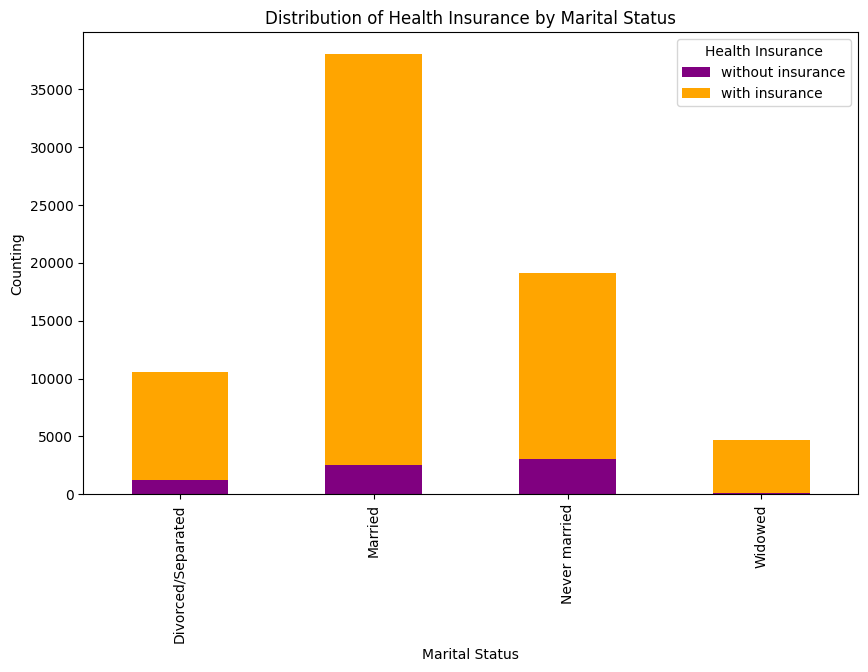

In [27]:
marital_health_counts = df.groupby(['marital_status', 'health_ins']).size().unstack()

marital_health_counts.plot(kind='bar', stacked=True, color=['purple', 'orange'], figsize=(10, 6))
plt.title('Distribution of Health Insurance by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Counting')
plt.legend(['without insurance', 'with insurance'], title='Health Insurance')
plt.show()

Most people with health insurance are married, while most people without health insurance are never married.

### Correlation structure
Pairwise correlations between numeric variables are examined to identify linear relationships and potential multicollinearity.


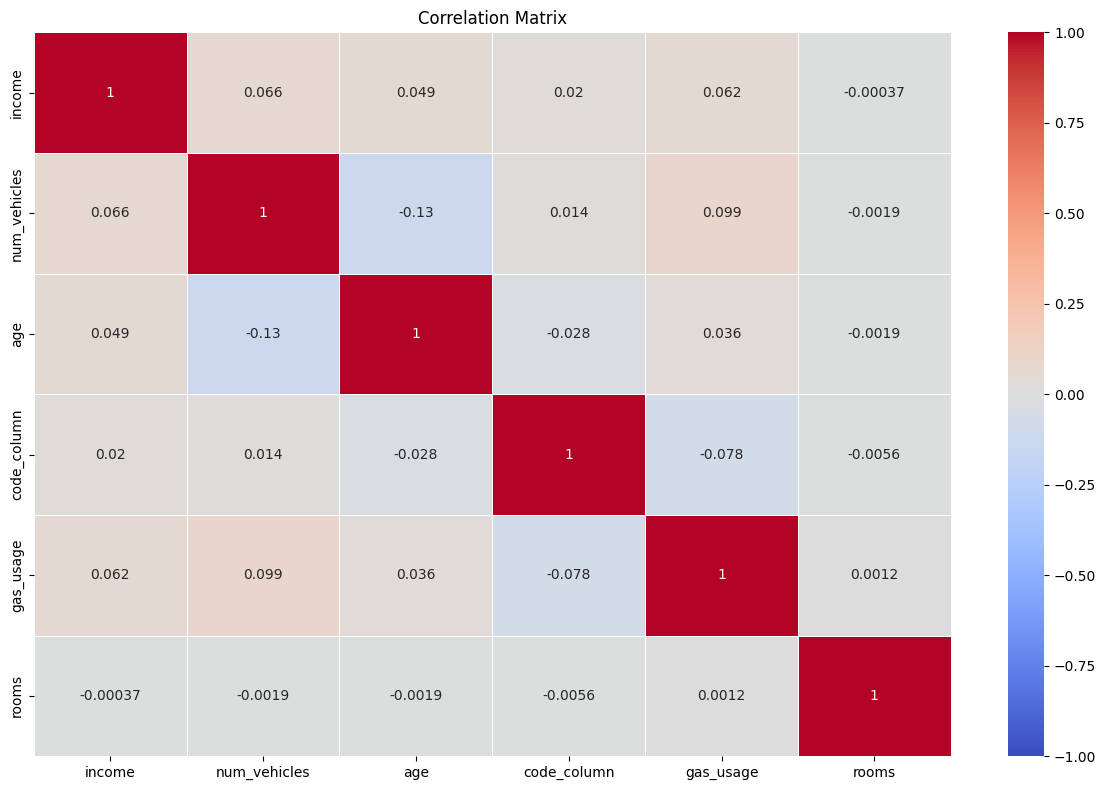

In [28]:
numeric_data = df.select_dtypes(include=['number']).drop(columns=['Unnamed: 0'])
corr = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


The more significant correlation, is a negative one between age and the number of vehicles.

## Preprocessing

### Feature removal
Identifier variables and non-informative columns are removed prior to modeling.


In [29]:
data = df.copy()

# Drop identifiers and auxiliary columns
data = data.drop(
    columns=["code_column", "Unnamed: 0", "custid"],
    errors="ignore"
)

data.columns


Index(['sex', 'is_employed', 'income', 'marital_status', 'health_ins',
       'housing_type', 'num_vehicles', 'age', 'state_of_res', 'gas_usage',
       'rooms', 'recent_move_b'],
      dtype='object')

### Employment status
Missing employment status values are treated as a separate category to preserve information about non-response.


In [30]:
# Treat missing employment status as an explicit category
data["is_employed"] = data["is_employed"].fillna("Not_in_Workforce")

data["is_employed"].value_counts(dropna=False)

data["is_employed"] = data["is_employed"].map(
    {True: "Employed", False: "Not_employed"}
).fillna(data["is_employed"]).astype(str)

data["is_employed"].value_counts(dropna=False)


is_employed
Employed            44630
Not_in_Workforce    25515
Not_employed         2313
Name: count, dtype: int64

### Income
Income includes zero and negative values. A sign-preserving log transform is applied to reduce skew while retaining information from negative values.


In [31]:
print("Income < 0:", (data["income"] < 0).sum())
print("Income = 0:", (data["income"] == 0).sum())
print("Income is NA:", data["income"].isna().sum())

pseudo_count = 1e-5

def transform_income(x):
    if pd.isna(x):
        return np.nan
    if x < 0:
        return -np.log(abs(x) + pseudo_count)
    return np.log(x + pseudo_count)

data["income_raw"] = data["income"]
data["income"] = data["income"].apply(transform_income)

display(data[["income_raw", "income"]].head(10))


Income < 0: 45
Income = 0: 6691
Income is NA: 0


,income_raw,income
0,22000.0,9.998798
1,23200.0,10.051908
2,21000.0,9.952278
3,37770.0,10.539270
4,39000.0,10.571317
5,11100.0,9.314700
6,25800.0,10.158130
7,34600.0,10.451609
8,25000.0,10.126631
9,31200.0,10.348173


Income and employment status are reconciled to ensure internal consistency between zero income and employment information.


In [32]:
# Rule 1:
# If employment is False and income is missing, set income to 0
mask_1 = (data["is_employed"] == False) & (data["income"].isna())
data.loc[mask_1, "income"] = 0

# Rule 2:
# If employment status is missing and income is 0, set employment to False
mask_2 = (data["is_employed"].isna()) & (data["income"] == 0)
data.loc[mask_2, "is_employed"] = False

# Sanity check
data[["is_employed", "income"]].isna().sum()


is_employed    0
income         0
dtype: int64

Rows with missing values across all household/behavior variables (housing type, number of vehicles, gas usage, recent move) are removed, as they contain no usable information for these features.


In [33]:
key_cols = ["housing_type", "num_vehicles", "gas_usage", "recent_move_b"]

missing_all = data[key_cols].isna().all(axis=1)
n_missing_all = missing_all.sum()

print("Rows missing all key household/behavior variables:", n_missing_all)
print("Share of dataset:", n_missing_all / len(data))

data = data.dropna(subset=key_cols, how="all")

print("New shape:", data.shape)


Rows missing all key household/behavior variables: 1686
Share of dataset: 0.023268652184713905
New shape: (70772, 13)


### Age
Age values above a threshold are capped to reduce the influence of extreme outliers. Remaining missing values are imputed using the median age.


In [34]:
data["age"] = data["age"].clip(upper=100)

median_age = data["age"].median()
data["age"] = data["age"].fillna(median_age)

print("Median age used for imputation:", median_age)
print("Missing ages after imputation:", data["age"].isna().sum())


Median age used for imputation: 48.0
Missing ages after imputation: 0


### Gas usage
Encoded gas usage values are recoded to reduce the influence of extreme or non-informative categories.


In [35]:
# Drop rows with missing gas usage (few remaining cases)
data = data.dropna(subset=["gas_usage"])

# Replace coded values with the mean / zero as defined
gas_mean = data["gas_usage"].mean()

data["gas_usage"] = data["gas_usage"].replace({
    1: gas_mean,
    2: gas_mean,
    3: 0
})

print("Gas usage summary after recoding:")
display(data["gas_usage"].describe())


Gas usage summary after recoding:


count    70772.000000
mean        45.151980
std         62.123853
min          0.000000
25%          0.000000
50%         30.000000
75%         60.000000
max        570.000000
Name: gas_usage, dtype: float64

In [36]:
data.isna().sum()


sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     1
income_raw        0
dtype: int64

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70772 entries, 0 to 72456
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             70772 non-null  object 
 1   is_employed     70772 non-null  object 
 2   income          70772 non-null  float64
 3   marital_status  70772 non-null  object 
 4   health_ins      70772 non-null  bool   
 5   housing_type    70772 non-null  object 
 6   num_vehicles    70772 non-null  float64
 7   age             70772 non-null  float64
 8   state_of_res    70772 non-null  object 
 9   gas_usage       70772 non-null  float64
 10  rooms           70772 non-null  int64  
 11  recent_move_b   70771 non-null  object 
 12  income_raw      70772 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(6)
memory usage: 7.1+ MB


## Modeling preparation
The preprocessed dataset is split into training and test sets. Categorical variables are encoded and numeric variables are passed through without scaling.


In [38]:
target = "health_ins"

X = data.drop(columns=target)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

# Preprocessing for modeling
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

Train shape: (56617, 12)
Test shape: (14155, 12)
Numeric features: ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms', 'income_raw']
Categorical features: ['sex', 'is_employed', 'marital_status', 'housing_type', 'state_of_res', 'recent_move_b']


### Baseline model
A logistic regression model is used as a simple baseline to provide a reference level of performance.


In [39]:
baseline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

baseline.fit(X_train, y_train)

baseline_proba = baseline.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, baseline_proba)

baseline_auc


0.7878442189523943

### Decision tree model
A shallow decision tree is trained to capture simple non-linear decision rules while remaining interpretable.


In [40]:
tree = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(
            max_depth=4,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

tree.fit(X_train, y_train)

tree_proba = tree.predict_proba(X_test)[:, 1]
tree_auc = roc_auc_score(y_test, tree_proba)

tree_auc

0.7637856047865373

### Random forest model
A random forest is trained to capture non-linear relationships and feature interactions while reducing variance compared to a single tree.


In [41]:
rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=5,
            random_state=42,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]
)

rf.fit(X_train, y_train)

rf_proba = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

rf_auc

0.8118522628547497

### XGBoost model
A gradient-boosted tree model is trained to capture non-linearities and interactions in tabular data with strong predictive performance.


In [42]:
xgb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=600,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ]
)

xgb.fit(X_train, y_train)

xgb_proba = xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_proba)

xgb_auc


0.8203759336025422

In [43]:
results = pd.DataFrame(
    {
        "model": ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
        "roc_auc": [baseline_auc, tree_auc, rf_auc, xgb_auc],
    }
).sort_values("roc_auc", ascending=False)

results


,model,roc_auc
3,XGBoost,0.820376
2,Random Forest,0.811852
0,Logistic Regression,0.787844
1,Decision Tree,0.763786


## Explainability

### Global and local explanations (XGBoost)
Post-hoc explainability is applied to the XGBoost model using SHAP to understand feature contributions at both the global and individual level.


In [44]:
model = xgb.named_steps["model"]
preprocess = xgb.named_steps["preprocess"]

X_train_enc = preprocess.transform(X_train)

num_features = numeric_cols
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)

feature_names = list(num_features) + list(cat_features)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_enc)

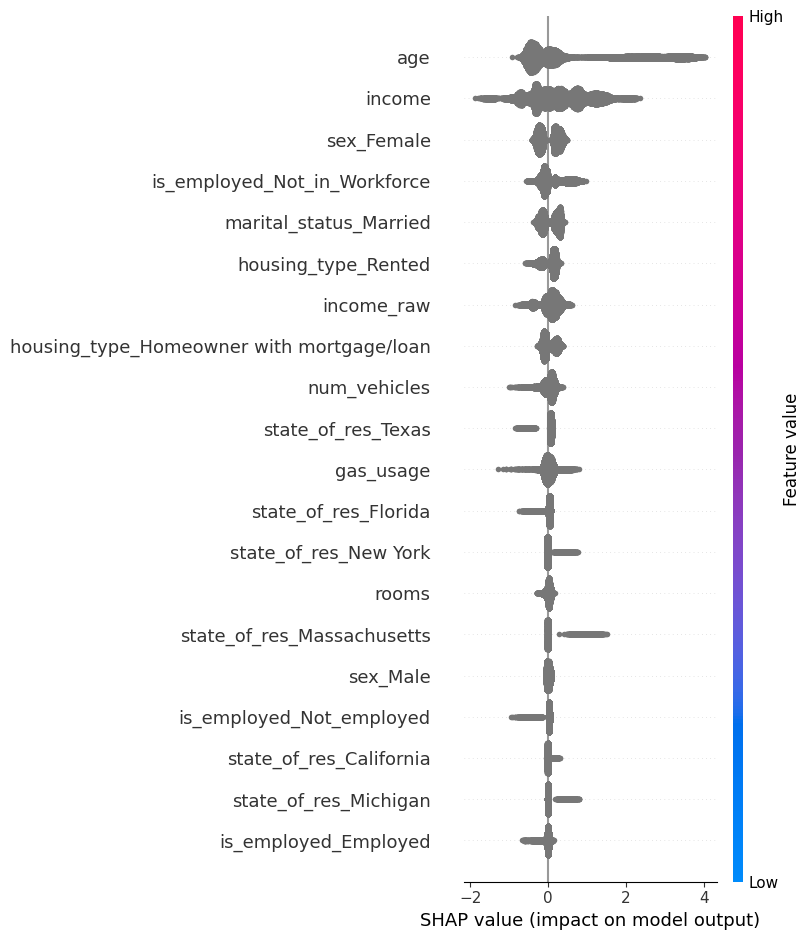

In [45]:
# Global explanation (feature impact across the training set)
shap.summary_plot(
    shap_values if not isinstance(shap_values, list) else shap_values[1],
    X_train_enc,
    feature_names=feature_names,
    show=True
)


### Local explanation
A local SHAP explanation is used to analyse the factors driving an individual prediction.


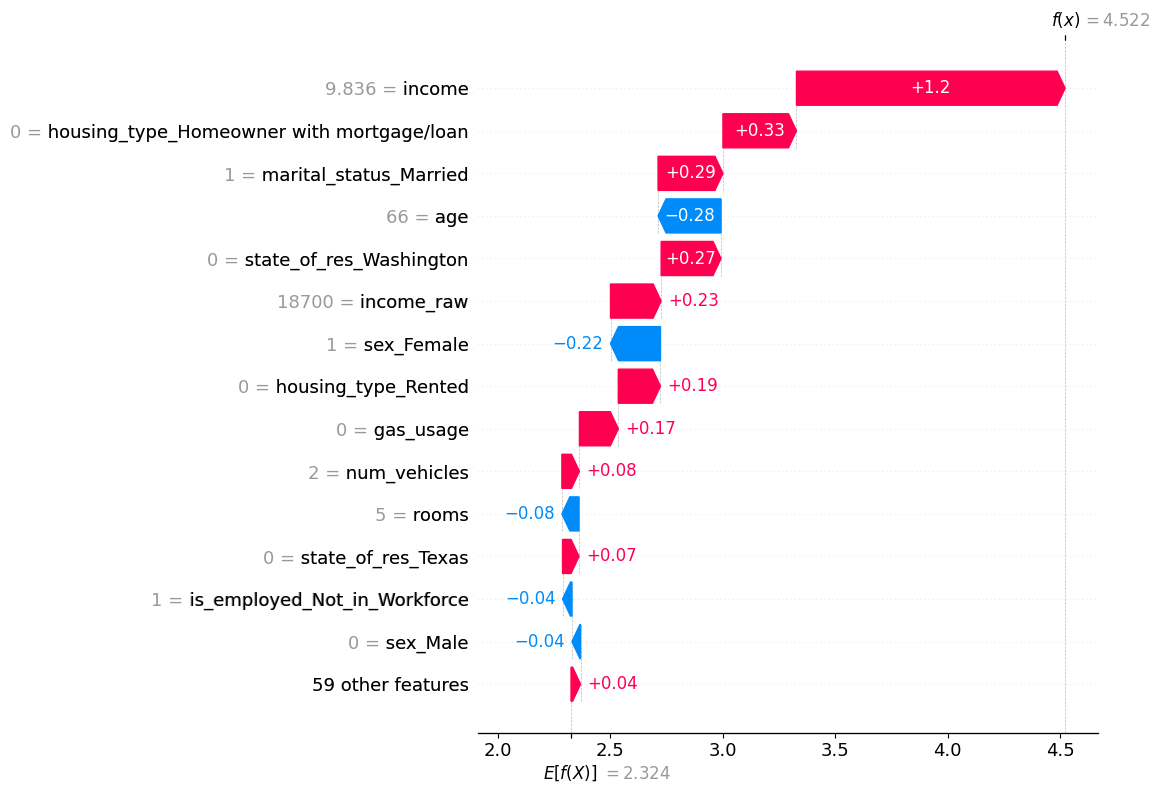

In [48]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx] if not isinstance(shap_values, list) else shap_values[1][idx],
        base_values=explainer.expected_value if not isinstance(shap_values, list) else explainer.expected_value[1],
        data=x_row,
        feature_names=feature_names
    ),
    max_display=15
)


This plot shows how the model arrives at the prediction for one individual. The starting point is the average model output, which is then adjusted by the contributions of individual features.

In this example, income clearly plays the largest role and pushes the prediction upward. Marital status and housing-related variables also contribute positively, but much less than income. Age has a small negative effect for this individual and slightly reduces the predicted probability.

Most of the remaining variables, such as location, number of vehicles, and gender, have only minor influence and mainly fine-tune the final prediction. Overall, the model’s decision is driven mostly by economic factors, with demographic and household characteristics playing a secondary role.

Compared to the logistic regression baseline, the XGBoost model achieves a higher ROC-AUC, indicating improved discrimination while remaining interpretable through post-hoc explanations.


## Limitations and future work

- The analysis is based on observational data; feature contributions should not be interpreted causally.
- Some variables exhibit data quality issues and rely on heuristic preprocessing rules.
- Model performance depends on the chosen decision threshold, which was not optimised for a specific business objective.
- Future work could explore fairness analysis, threshold calibration, and validation on external datasets.
